This is my attempt at following <a href = "https://medium.com/@julsimon/predicting-world-temperature-with-time-series-and-deepar-on-amazon-sagemaker-e371cf94ddb5">this tutorial</a> that I found online. Thanks Julien Simon! Here is a link to <a href = "https://github.com/juliensimon/dlnotebooks/blob/master/sagemaker/04-DeepAR-temperatures.ipynb">his original notebook</a> on his GitHub page.

My goal is to plug my ferry data into this.

In [3]:
# Our model will predict temperature for the next 'prediction_length' days
prediction_length = 30
bucket = '######'

In [6]:
import csv, boto3, json, sagemaker
import numpy as np
import pandas as pd

In [7]:
data_key = 'Bainbridge_Departures_2013_Interpolated.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")

Going to split that data up by month into a dictionary.

<a href = "https://stackoverflow.com/questions/6557553/get-month-name-from-number">Get month name from number</a>

In [119]:
import calendar

dataset = {}

year = 2013

for i in range(1,13):
    index = "2013-{}".format(i)
    key = "{} {}".format(calendar.month_name[i], year)
    dataset[key] = list(df[index]["seconds_late"])

## Plot data set

In [122]:
x = df["seconds_late"].index
y = df["seconds_late"].values

Number of samples: 105109


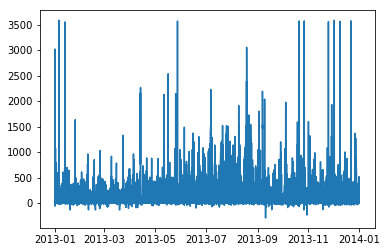

In [123]:
import matplotlib.pyplot as plt

nbSamples = len(x)
print('Number of samples: %d' % nbSamples)

#fig=plt.figure(figsize=(64, 16))
plt.plot(x,y)
plt.show()

## Prepare training set and test set

In [124]:
# According to https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# - remove the last 'prediction_length' points from each time series
# - use the full data set for testing
# - no need to shuffle the training set: dictionaries are not ordered :)

trainingSet = dataset.copy()
trainingSet[year] = { year: dataset[year][:-prediction_length] for year in dataset.keys() }

testSet = dataset.copy()

In [88]:
df.tail(5)

,departure_terminal,arrival_terminal,scheduled_departure,actual_departure,Actual_Arrival,TransitTime,seconds_late
timestamps,,,,,,,
2013-12-31 23:35:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:40:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:45:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:50:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:55:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0


<a href = "https://stackoverflow.com/questions/3418050/month-name-to-month-number-and-vice-versa-in-python">month name to month number and vice versa in python</a>

In [125]:
months_to_number = {v: k for k,v in enumerate(calendar.month_name)}

In [128]:
train_key      = 'bainbridge_2013_deepar_training.json'
test_key       = 'bainbridge_2013_deepar_test.json'

def writeDataset(filename, data):
    file=open(filename,'w')
    for key in dataset.keys():
        # One JSON sample per line
        month, year = key.split(" ")
        line = "\"start\":\"{}-{}-01 00:00:00\",\"target\":{}".format(year, months_to_number[month],dataset[key])
        file.write('{'+line+'}\n')

In [129]:
writeDataset(train_key, trainingSet)        
writeDataset(test_key, testSet)

In [131]:
#!head -20 bainbridge_2013_deepar_training.json

## Upload training set and test set to S3

In [132]:
prefix         = 'sagemaker/ferry-deepar-julian'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [133]:
sagemaker_session = sagemaker.Session()
role              = sagemaker.get_execution_role()
region            = boto3.Session().region_name

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

print(train_path)
print(test_path)
print(output_path)

s3://example-bucket-99/sagemaker/ferry-deepar-julian/train/bainbridge_2013_deepar_training.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/test/bainbridge_2013_deepar_test.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/output


## Configure training job

In [134]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}

image_name = containers[region]

In [147]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='ferry-predictor',
    output_path=output_path
)

In [148]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": '5min',
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimator.set_hyperparameters(**hyperparameters)

## Run training job

In [149]:
print(train_path)
print(test_path)
print(output_path)

data_channels = {"train": train_path, "test": test_path}

s3://example-bucket-99/sagemaker/ferry-deepar-julian/train/bainbridge_2013_deepar_training.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/test/bainbridge_2013_deepar_test.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/output


In [150]:
%%time

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: ferry-predictor-2019-03-29-16-19-13-161


2019-03-29 16:19:13 Starting - Starting the training job...
2019-03-29 16:19:14 Starting - Launching requested ML instances......
2019-03-29 16:20:24 Starting - Preparing the instances for training......
2019-03-29 16:21:21 Downloading - Downloading input data...
2019-03-29 16:21:56 Training - Training image download completed. Training in progress.
Arguments: train
[03/29/2019 16:21:59 INFO 140545655179072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[03/

[03/29/2019 16:22:10 INFO 140545655179072] Epoch[9] Batch[0] avg_epoch_loss=8.071934
[03/29/2019 16:22:10 INFO 140545655179072] Epoch[9] Batch[5] avg_epoch_loss=24.106121
[03/29/2019 16:22:10 INFO 140545655179072] Epoch[9] Batch [5]#011Speed: 492.42 samples/sec#011loss=24.106121
[03/29/2019 16:22:11 INFO 140545655179072] Epoch[9] Batch[10] avg_epoch_loss=689.914242
[03/29/2019 16:22:11 INFO 140545655179072] Epoch[9] Batch [10]#011Speed: 405.55 samples/sec#011loss=1488.883986
[03/29/2019 16:22:11 INFO 140545655179072] processed a total of 334 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1051.5401363372803, "sum": 1051.5401363372803, "min": 1051.5401363372803}}, "EndTime": 1553876531.286494, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1553876530.234639}

[03/29/2019 16:22:11 INFO 140545655179072] #throughput_metric: host=algo-1, train throughput=317.599168242 records/second
[03/29/2019 16:22:11 INFO 1405456551790

## Deploy model

In [151]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

INFO:sagemaker:Creating model with name: ferry-predictor-2019-03-29-16-19-13-161
INFO:sagemaker:Creating endpoint-config with name ferry-predictor-2019-03-29-16-19-13-161
INFO:sagemaker:Creating endpoint with name ferry-predictor-2019-03-29-16-19-13-161


--------------------------------------------------------------------------!CPU times: user 440 ms, sys: 14.4 ms, total: 455 ms
Wall time: 6min 15s


## Build JSON-formatted prediction request

In [158]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(month, year, data):
    #pdb.set_trace()
    month_delays = dataset["{} {}".format(month, year)]
    s = {"start": "{}-{}-01 00:00:00".format(year, months_to_number[month]), "target": month_delays}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

## Get predicted series from response

In [153]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

## Plot predicted series and ground truth

In [154]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

## Example: predict temperature for the last 'prediction_length' days and compare to ground truth

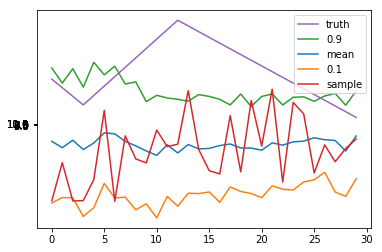

In [162]:
month = 'March' # “He who controls the past controls the future. He who controls the present controls the past.”
year = 2013

prediction_data = buildPredictionData(month, year, trainingSet)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet["{} {}".format(month, year)][-prediction_length:], 
           truth_label='truth')

In [168]:
y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)

In [170]:
truth_data=testSet["{} {}".format(month, year)][-prediction_length:]

# Left off

In [171]:
truth_data

[188.0,
 154.0,
 120.0,
 86.0,
 123.22222222222223,
 160.44444444444446,
 197.66666666666663,
 234.88888888888889,
 272.1111111111111,
 309.3333333333333,
 346.5555555555556,
 383.77777777777777,
 421.0,
 398.38888888888886,
 375.77777777777777,
 353.16666666666674,
 330.5555555555556,
 307.9444444444445,
 285.33333333333337,
 262.72222222222223,
 240.11111111111111,
 217.5,
 194.88888888888889,
 172.27777777777774,
 149.66666666666669,
 127.05555555555556,
 104.44444444444444,
 81.83333333333331,
 59.22222222222222,
 36.61111111111114]

## Example: predict temperature for the next 'prediction_length' days

In [ ]:
# Predict temperature for the next 'prediction_length' days of 2018
year = 2018
year_temps={}
year_temps[str(year)] = np.random.normal(9, 1.5, 90).tolist()

prediction_data = buildPredictionData(year, year_temps)
result = predictor.predict(prediction_data).encode('utf-8')
plotSeries(result)

## Clean up

In [ ]:
print(job_name)
sm = boto3.client('sagemaker')
sm.delete_endpoint(EndpointName=job_name)
sm.delete_endpoint_config(EndpointConfigName=job_name)
sm.delete_model(ModelName=job_name)